In [1]:
import torch
import matplotlib.pyplot as plt
from trainSettings import *
from helpersPlot import *
import pandas as pd


In [2]:
trajs, labels = models_phenom().single_state(1, 
                            L=0,
                            T=T,
                            Ds=0.1,  # Mean and variance
                            alphas=1)
# Reshape trajectories
trajs = trajs.transpose(1, 0, 2)
trajs = trajs / traj_div_factor


vids = trajectories_to_video(trajs,nPosPerFrame,False,image_props)

vids = trajectories_to_video(np.zeros_like(trajs),nPosPerFrame,False,image_props)
play_video(vids[0], vmin=0, vmax=7500)
trajs, labels = models_phenom().single_state(1, 
                            L=0,
                            T=T,
                            Ds=7,  # Mean and variance
                            alphas=1)
# Reshape trajectories
trajs = trajs.transpose(1, 0, 2)
trajs = trajs / traj_div_factor
vids = trajectories_to_video(trajs,nPosPerFrame,False,image_props)
play_video(vids[0], vmin=0, vmax=7500)

vmin: 0 vmax: 7500 mean: 1797.96


Particle Left the image
Particle Left the image
Particle Left the image
vmin: 0 vmax: 7500 mean: 1633.60


In [3]:
length = 30

trajs1 = np.load("./valTrajs"+str(length)+"/val1.npy") /traj_div_factor
trajs3 = np.load("./valTrajs"+str(length)+"/val3.npy") /traj_div_factor
trajs5 = np.load("./valTrajs"+str(length)+"/val5.npy") /traj_div_factor
trajs7 = np.load("./valTrajs"+str(length)+"/val7.npy") /traj_div_factor
trajs_in_order = np.load("./valTrajsInOrder.npy") /traj_div_factor

In [ ]:
def trajectories_to_video_multiple_settings(
    trajectories,
    nPosPerFrame,
    center = False,
    image_props={},
):
    
    N,T,_ = trajectories.shape

# Invert the y axis, for video creation purposes where y-axis is inverted
    trajectories[:, :, 1] *= -1


    if(T % nPosPerFrame != 0):
        raise Exception("T is not divisble by posPerFrame")

    nFrames = T // nPosPerFrame

    _image_dict = {
        "particle_intensity": [
            500,
            20,
        ],  # Mean and standard deviation of the particle intensity
        "NA": 1.46,  # Numerical aperture
        "wavelength": 500e-9,  # Wavelength
        "psf_division_factor": 1, 
        "resolution": 100e-9,  # Camera resolution or effective resolution, aka pixelsize
        "output_size": 32,
        "upsampling_factor": 5,
        "background_intensity": [
            100,
            10,
        ],  # Standard deviation of background intensity within a video
        "poisson_noise": 1,
        "trajectory_unit" : 100
    }

    # Update the dictionaries with the user-defined values
    _image_dict.update(image_props)
    resolution =_image_dict["resolution"]
    traj_unit = _image_dict["trajectory_unit"]
    
    if(traj_unit !=-1 ):
        trajectories = trajectories * traj_unit* 1e-9 / resolution

    output_size = _image_dict["output_size"]
    upsampling_factor = _image_dict["upsampling_factor"]
    psf_div_factor = _image_dict["psf_division_factor"]
    
    # Psf is computed as wavelenght/2NA according to:
    #https://www.sciencedirect.com/science/article/pii/S0005272819301380?via%3Dihub
    fwhm_psf = _image_dict["wavelength"] / 2 * _image_dict["NA"] / psf_div_factor

    
    gaussian_sigma = upsampling_factor/ resolution * fwhm_psf/2.355
    poisson_noise = _image_dict["poisson_noise"]
    
    out_videos_no_noise = np.zeros((N,nFrames,output_size,output_size),np.float32)
    out_videos_gauss_noise = np.zeros((N,nFrames,output_size,output_size),np.float32)
    out_videos_Poisson = np.zeros((N,nFrames,output_size,output_size),np.float32)
    out_videos_RL = np.zeros((N,nFrames,output_size,output_size),np.float32)
    out_videos_gauss_filter = np.zeros((N,nFrames,output_size,output_size),np.float32)

    particle_mean, particle_std = _image_dict["particle_intensity"][0],_image_dict["particle_intensity"][1]
    background_mean, background_std = _image_dict["background_intensity"][0],_image_dict["background_intensity"][1]
    
    for n in range(N):
        trajectory_to_videoTest(out_videos_no_noise[n,:],out_videos_gauss_noise[n,:],out_videos_Poisson[n,:],out_videos_RL[n,:],out_videos_gauss_filter[n,:],trajectories[n,:],nFrames,output_size,upsampling_factor,nPosPerFrame,
                                                gaussian_sigma,particle_mean,particle_std,background_mean,background_std, poisson_noise,center)
        
    return out_videos_no_noise,out_videos_gauss_noise, out_videos_Poisson, out_videos_RL, out_videos_gauss_filter


def trajectory_to_videoTest(out_video_no_noise,out_video_gauss_noise, out_video_poiss_noise, out_video_RL, out_video_gauss_filter,trajectory,nFrames, output_size, upsampling_factor, nPosPerFrame,gaussian_sigma,particle_mean,particle_std,background_mean,background_std, poisson_noise, center):
    """Helper function of function above, all arguments documented above"""
    for f in range(nFrames):
        frame_hr = np.zeros(( output_size*upsampling_factor, output_size*upsampling_factor),np.float32)
        frame_lr = np.zeros((output_size, output_size),np.float32)

        start = f*nPosPerFrame
        end = (f+1)*nPosPerFrame
        trajectory_segment = (trajectory[start:end,:] - np.mean(trajectory[start:end,:],axis=0) if center else trajectory[start:end,:]) 
        xtraj = trajectory_segment[:,0]  * upsampling_factor
        ytraj = trajectory_segment[:,1] * upsampling_factor

        

        # Generate frame, convolution, resampling, noise
        for p in range(nPosPerFrame):
            if(particle_mean >0.0001 and particle_std > 0.0001):
                spot_intensity = np.random.normal(particle_mean/nPosPerFrame,particle_std/nPosPerFrame)
                frame_spot = gaussian_2d(xtraj[p], ytraj[p], gaussian_sigma, output_size*upsampling_factor, spot_intensity)

                # gaussian_2d maximum is not always the wanted one because of some misplaced pixels. 
                # We can force the peak of the gaussian to have the right intensity
                spot_max = np.max(frame_spot)
                if(spot_max < 0.00001):
                    print("Particle Left the image")
                frame_hr += spot_intensity/spot_max * frame_spot
        
        frame_lr = block_reduce(frame_hr, block_size=upsampling_factor, func=np.mean)
        # Add Gaussian noise to background intensity across the image
        frame_no_noise = frame_lr.copy()
        frame_lr += np.clip(np.random.normal(background_mean, background_std, frame_lr.shape), 
                                    0, background_mean + 3 * background_std)

        frame_lr_poisson = np.random.poisson(frame_lr * poisson_noise) / poisson_noise

        # TO CHANGE !!
        frame_RL = frame_lr
        frame_gaussian_filter = ski.filters.gaussian(frame_lr_poisson, sigma=0.5)  # mild smoothing

        out_video_no_noise[f,:] = frame_no_noise
        out_video_gauss_noise[f,:] = frame_lr
        out_video_poiss_noise[f,:] = frame_lr_poisson
        out_video_RL[f,:] = frame_RL
        out_video_gauss_filter[f,:] = frame_gaussian_filter

    return 

In [36]:
print(trajs1.shape)

v1_no, v1_gn, v1_pn, v1_rl, v1_gf = trajectories_to_video_multiple_settings(trajs1,nPosPerFrame,center,image_props)
v7_no, v7_gn, v7_pn, v7_rl, v7_gf = trajectories_to_video_multiple_settings(trajs7,nPosPerFrame,center,image_props)

print(v1_no.shape)

(50, 300, 2)
(50, 30, 9, 9)


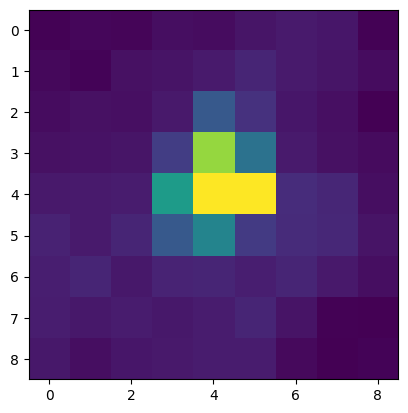

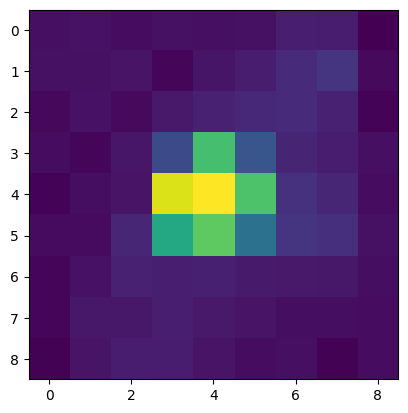

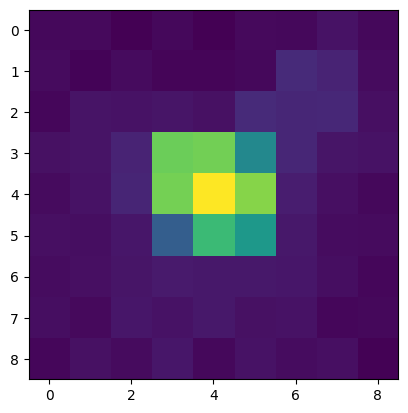

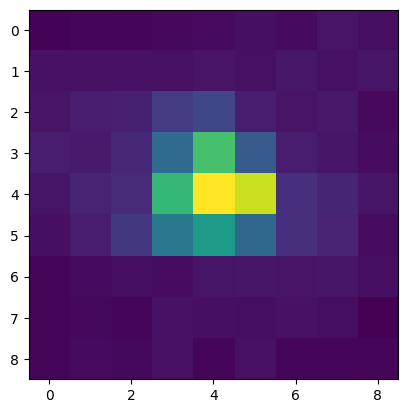

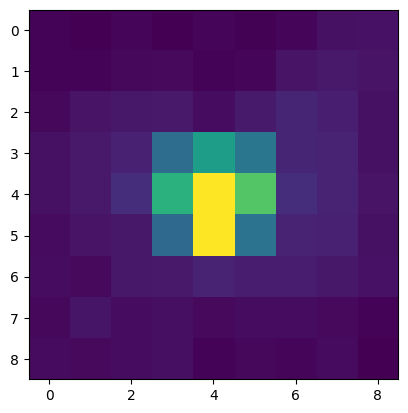

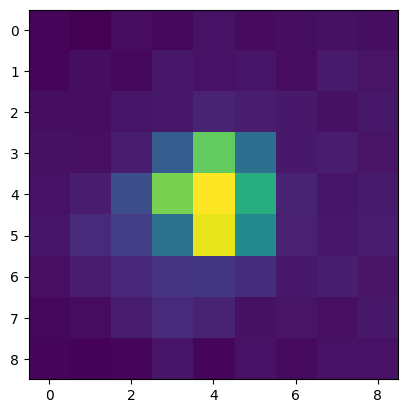

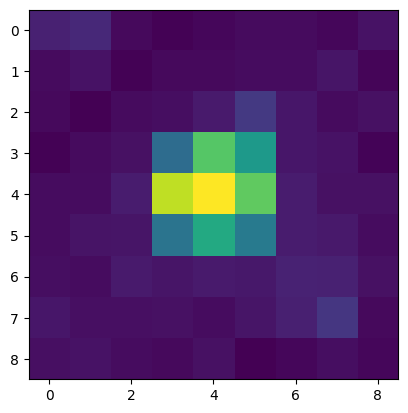

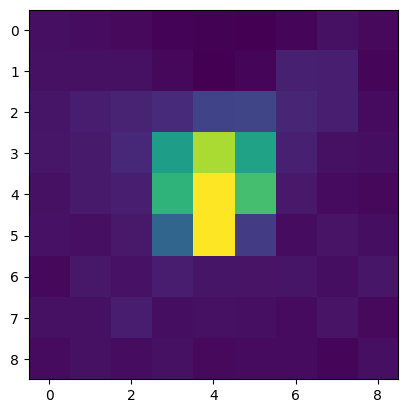

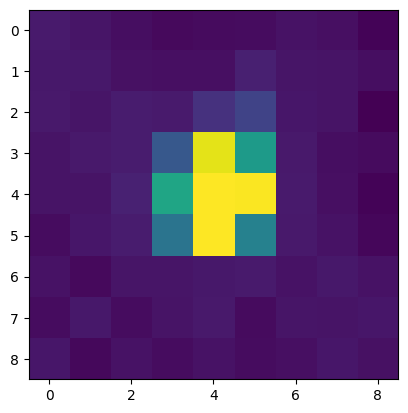

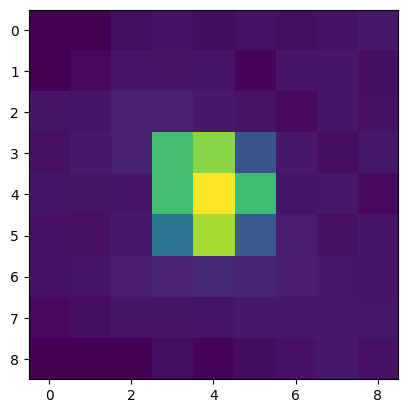

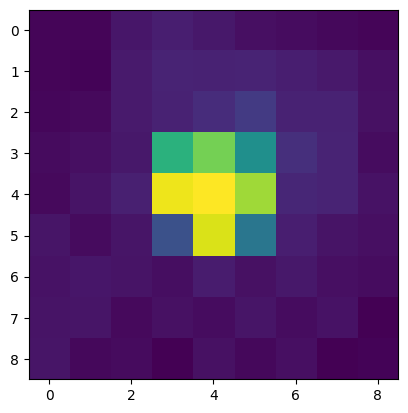

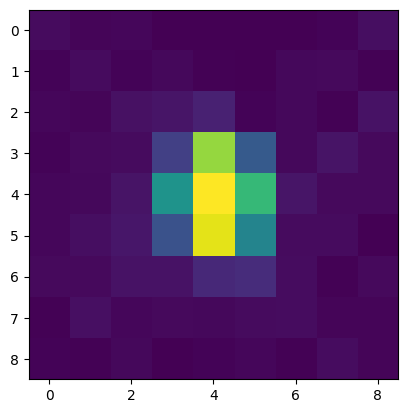

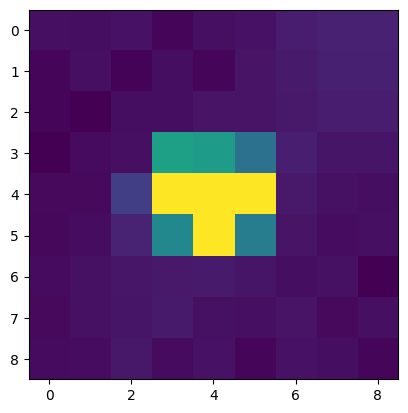

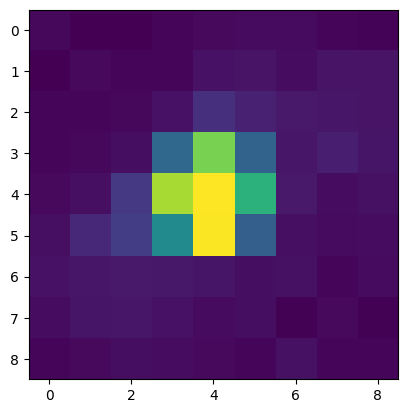

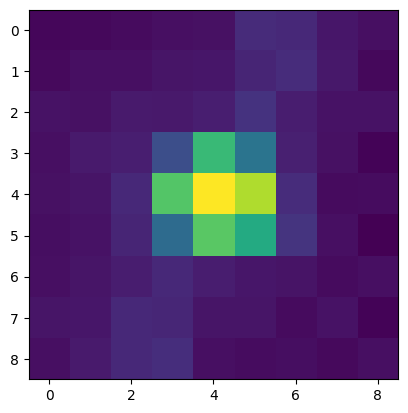

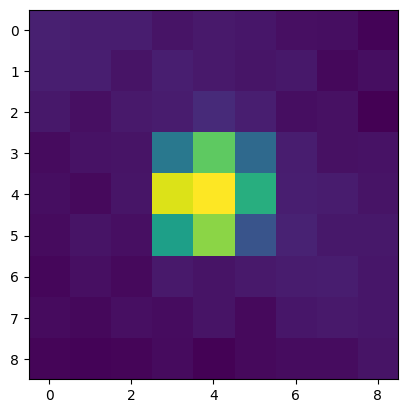

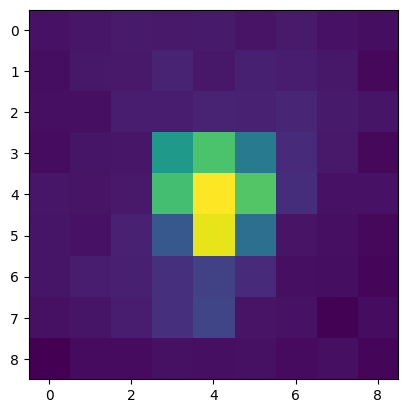

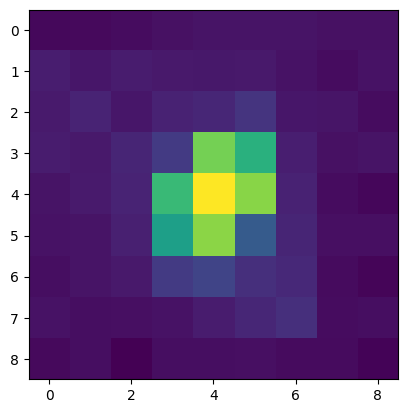

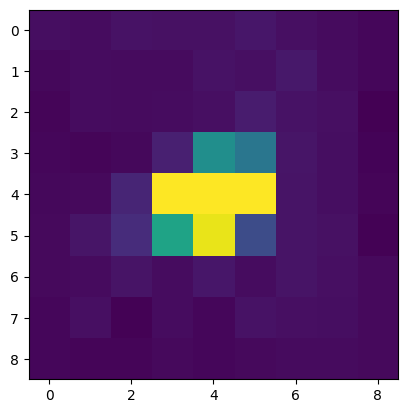

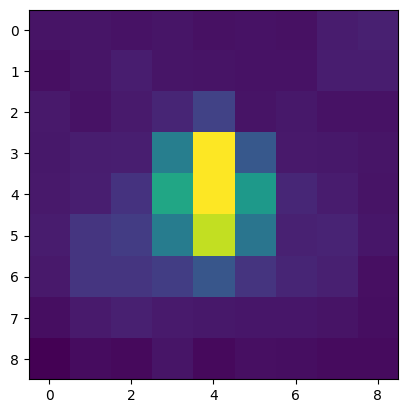

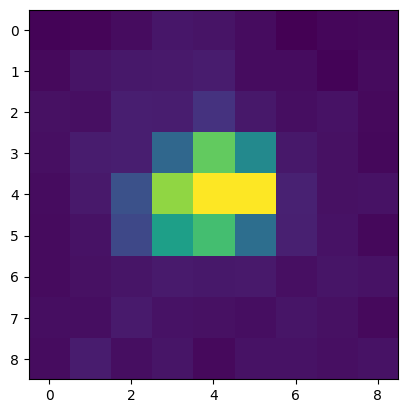

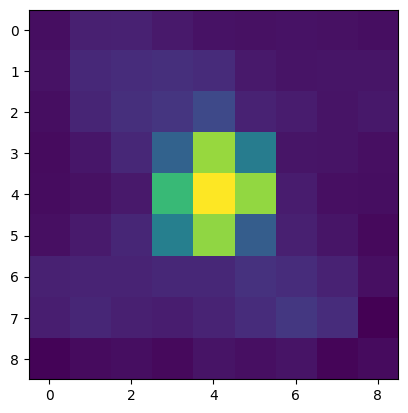

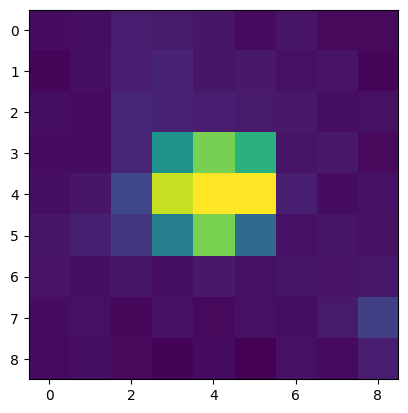

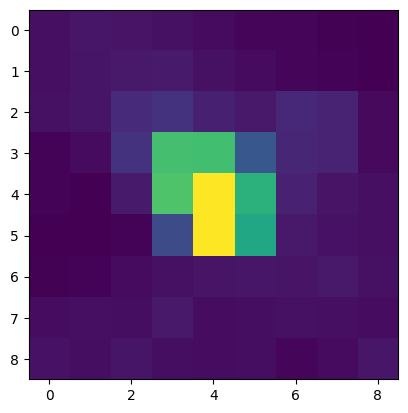

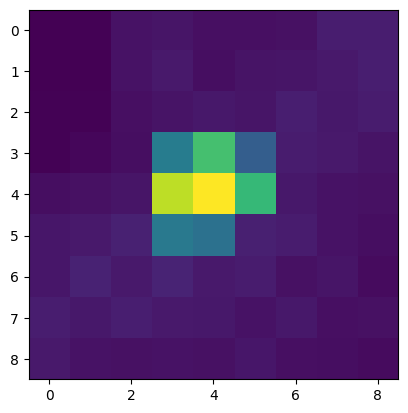

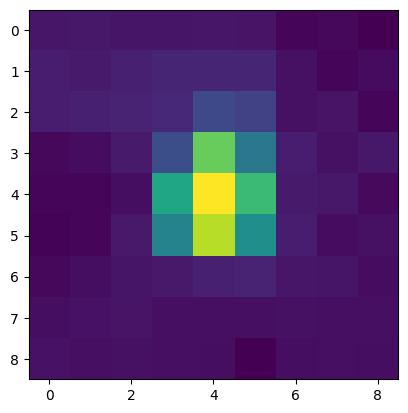

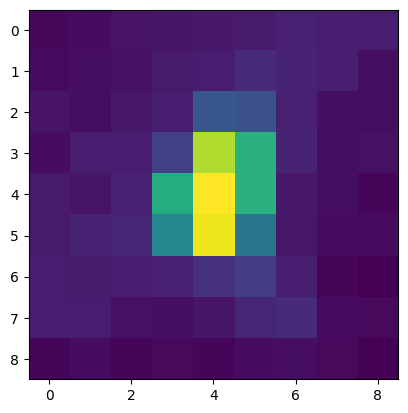

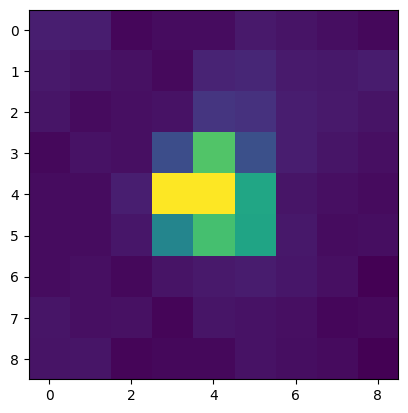

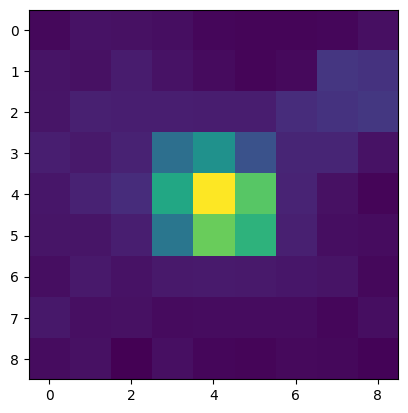

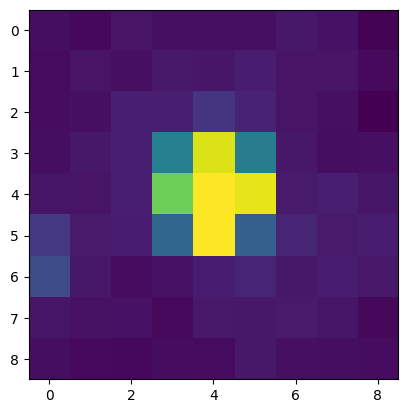

In [ ]:
from scipy.signal import fftconvolve

def tv_gradient(image):
    """Compute the gradient of total variation."""
    grad = np.zeros_like(image)
    dx = np.diff(image, axis=1, append=image[:, -1:])
    dy = np.diff(image, axis=0, append=image[-1:, :])
    eps = 1e-8
    mag = np.sqrt(dx**2 + dy**2 + eps)
    dx_norm = dx / mag
    dy_norm = dy / mag
    grad[:, :-1] -= dx_norm[:, :-1]
    grad[:, 1:] += dx_norm[:, :-1]
    grad[:-1, :] -= dy_norm[:-1, :]
    grad[1:, :] += dy_norm[:-1, :]
    return grad

def richardson_lucy_tv(image, psf, iterations=20, tv_weight=0.01):
    image = np.clip(image, 1e-6, None)
    psf_mirror = psf[::-1, ::-1]
    estimate = np.full(image.shape, 0.5, dtype=np.float32)
    for i in range(iterations):
        relative_blur = image / (fftconvolve(estimate, psf, mode='same') + 1e-6)
        correction = fftconvolve(relative_blur, psf_mirror, mode='same')
        estimate *= correction
        tv_grad = tv_gradient(estimate)
        estimate -= tv_weight * tv_grad
        estimate = np.clip(estimate, 0, 1)

    return estimate


def create_gaussian_psf(size=patch_size, sigma=1.3):
    if size % 2 == 0:
        size += 1  # ensure odd size for symmetry
    ax = np.arange(-size // 2 + 1, size // 2 + 1)
    x, y = np.meshgrid(ax, ax)
    psf = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    psf /= psf.sum()
    return psf
def pad_image_to_size(image, target_size):
    """
    Pads a 2D image with zeros to reach target_size x target_size.
    """
    h, w = image.shape
    pad_h = max(target_size - h, 0)
    pad_w = max(target_size - w, 0)
    
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    return np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='edge')



psf = create_gaussian_psf(sigma=1)

from skimage import restoration

v1_no, v1_gn, v1_pn, v1_rl, v1_gf = trajectories_to_video_multiple_settings(trajs1,nPosPerFrame,center,image_props)
v7_no, v7_gn, v7_pn, v7_rl, v7_gf = trajectories_to_video_multiple_settings(trajs7,nPosPerFrame,center,image_props)

for i in range(nFrames):
    #v1_rl[0,i] = richardson_lucy_tv(normalize_images(v1_rl[0,i],background_mean,background_sigma,part_mean+ background_mean)[0], psf, iterations=2, tv_weight=0.01)
    im = normalize_images(v1_rl[0,i],background_mean,background_sigma,part_mean+ background_mean)[0]

    n_iters = 20
    im2 = restoration.richardson_lucy(im, psf, num_iter=n_iters)
    im2 = richardson_lucy_tv(im, psf, iterations=n_iters, tv_weight=0.01)
    #plt.imshow(im2)
    #plt.show()
    
    #v1_rl[0,i] = im2
    #plt.imshow(im2)
    #plt.show()
    v7_rl[0,i] = richardson_lucy_tv(normalize_images(v7_rl[0,i],background_mean,background_sigma,part_mean+ background_mean)[0], psf, iterations=n_iters, tv_weight=0.01)



In [67]:
play_video(v1_no[0], vmin=None, vmax=None)
play_video(v1_gn[0], vmin=None, vmax=None)
play_video(v1_pn[0], vmin=None, vmax=None)
play_video(v1_rl[0], vmin=None, vmax=None)
play_video(v1_gf[0], vmin=None, vmax=None)

vmin: 0.06539660692214966 vmax: 3389.555419921875 mean: 369.91


vmin: 253.6267852783203 vmax: 4948.3310546875 mean: 1775.80


vmin: 250.08999633789062 vmax: 4950.5 mean: 1775.80


vmin: 0.0 vmax: 1.0 mean: 0.13


vmin: 623.99755859375 vmax: 4478.69482421875 mean: 1775.79


In [65]:
play_video(v7_no[0], vmin=None, vmax=None)
play_video(v7_gn[0], vmin=None, vmax=None)
play_video(v7_pn[0], vmin=None, vmax=None)
play_video(v7_rl[0], vmin=None, vmax=None)
play_video(v7_gf[0], vmin=None, vmax=None)

vmin: 0.07711021602153778 vmax: 3156.95654296875 mean: 365.83


vmin: 439.8774108886719 vmax: 4733.9873046875 mean: 1790.52


vmin: 440.3699951171875 vmax: 4743.93017578125 mean: 1790.54


vmin: 0.0 vmax: 1.0 mean: 0.13


vmin: 736.6748046875 vmax: 4265.28515625 mean: 1790.53
